In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
pratik2901_animal_dataset_path = kagglehub.dataset_download('pratik2901/animal-dataset')

print('Data source import complete.')


100%|██████████| 225M/225M [00:07<00:00, 33.5MB/s]

Extracting files...


Data source import complete.


# Animal Pytorch Lightning CNN

In [ ]:
!pip install pytorch-lightning
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset, Subset
from torch.utils.data import random_split, SubsetRandomSampler
from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from pytorch_lightning import LightningModule
from pytorch_lightning import Trainer
import pytorch_lightning as pl
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 46.4 MB/s eta 0:00:00


In [ ]:
transform=transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

In [ ]:
import os
dataset_root = os.path.join(pratik2901_animal_dataset_path, 'animal_dataset_intermediate', 'train')
dataset0=datasets.ImageFolder(root=dataset_root,transform=None)

class_names=dataset0.classes
print(class_names)
print(len(class_names))

['elefante_train', 'farfalla_train', 'mucca_train', 'pecora_train', 'scoiattolo_train']
5


In [ ]:
!mkdir datasets

In [ ]:
class DataModule(pl.LightningDataModule):

    def __init__(self, transform=transform, batch_size=32):
        super().__init__()
        self.root_dir = os.path.join(pratik2901_animal_dataset_path, 'animal_dataset_intermediate', 'train')
        self.transform = transform
        self.batch_size = batch_size

    def setup(self, stage=None):
        dataset = datasets.ImageFolder(root=self.root_dir, transform=self.transform)
        n_data = len(dataset)
        n_train = int(0.6 * n_data)
        n_valid =  int(0.2 * n_data)
        n_test = n_data - n_train - n_valid

        train_dataset, val_dataset, test_dataset= torch.utils.data.random_split(dataset, [n_train, n_valid, n_test])

        self.train_dataset = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        self.val_dataset = DataLoader(val_dataset, batch_size=self.batch_size)
        self.test_dataset = DataLoader(test_dataset, batch_size=self.batch_size)

    def train_dataloader(self):
        return self.train_dataset

    def val_dataloader(self):
        return self.val_dataset

    def test_dataloader(self):
        return self.test_dataset


In [ ]:
class ConvolutionalNetwork(LightningModule):

    def __init__(self):
        super(ConvolutionalNetwork, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(16 * 54 * 54, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 20)
        self.fc4 = nn.Linear(20, len(class_names))

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 16 * 54 * 54)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))
        X = self.fc4(X)
        return F.log_softmax(X, dim=1)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        X, y = train_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("train_loss", loss)
        self.log("train_acc", acc)
        return loss

    def validation_step(self, val_batch, batch_idx):
        X, y = val_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("val_loss", loss)
        self.log("val_acc", acc)

    def test_step(self, test_batch, batch_idx):
        X, y = test_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("test_loss", loss)
        self.log("test_acc", acc)

In [ ]:
if __name__ == '__main__':
    datamodule = DataModule()
    datamodule.setup()
    model = ConvolutionalNetwork()
    trainer = pl.Trainer(max_epochs=60)
    trainer.fit(model, datamodule)

Epoch 59/59 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154/154 0:01:33 • 0:00:00 1.63it/s v_num: 0.000

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=60` reached.


In [ ]:
datamodule = DataModule()
datamodule.setup()
model = ConvolutionalNetwork()
trainer = pl.Trainer(max_epochs=60)
trainer.fit(model, datamodule)

datamodule.setup(stage='test')
test_loader = datamodule.test_dataloader()
trainer.test(model, dataloaders=test_loader)

INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores


┏━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name  ┃ Type   ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ conv1 │ Conv2d │    168 │ train │     0 │
│ 1 │ conv2 │ Conv2d │    880 │ train │     0 │
│ 2 │ fc1   │ Linear │  5.6 M │ train │     0 │
│ 3 │ fc2   │ Linear │ 10.2 K │ train │     0 │
│ 4 │ fc3   │ Linear │  1.7 K │ train │     0 │
│ 5 │ fc4   │ Linear │    105 │ train │     0 │
└───┴───────┴────────┴────────┴───────┴───────┘

Trainable params: 5.6 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 5.6 M                                                                                                
Total estimated model params size (MB): 22                                                                         
Modules in train mode: 6                                                                                           
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=60` reached.


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8719512224197388     │
│         test_loss         │    0.6498801708221436     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.6498801708221436, 'test_acc': 0.8719512224197388}]

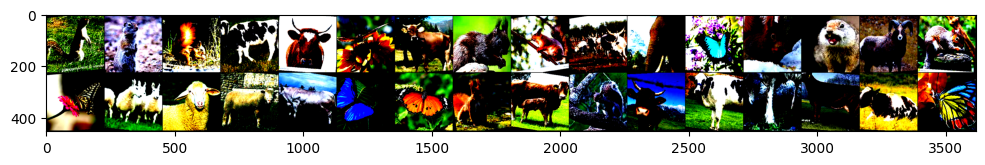

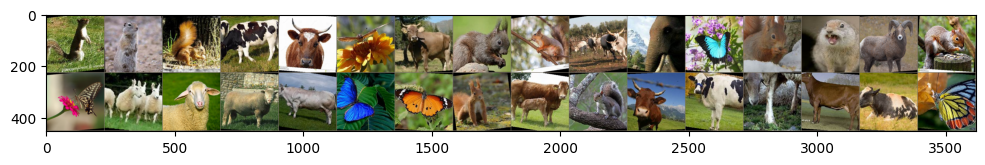

In [ ]:
for images, labels in datamodule.train_dataloader():
    break
im=make_grid(images,nrow=16)

plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

inv_normalize=transforms.Normalize(mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225],
                                   std=[1/0.229,1/0.224,1/0.225])
im=inv_normalize(im)

plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [ ]:
device = torch.device("cpu")   #"cuda:0"

model.eval()
y_true=[]
y_pred=[]
with torch.no_grad():
    for test_data in datamodule.test_dataloader():
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

print(classification_report(y_true,y_pred,target_names=class_names,digits=4))

                  precision    recall  f1-score   support

  elefante_train     0.8281    0.8773    0.8520       269
  farfalla_train     0.9808    0.9321    0.9558       383
     mucca_train     0.8953    0.7887    0.8386       336
    pecora_train     0.7879    0.8910    0.8363       321
scoiattolo_train     0.8584    0.8610    0.8597       331

        accuracy                         0.8713      1640
       macro avg     0.8701    0.8700    0.8685      1640
    weighted avg     0.8758    0.8713    0.8720      1640

